
# Email Deliverability Health Analysis 📧

This notebook explores a synthetic dataset simulating email deliverability metadata. We'll perform exploratory data analysis (EDA) and train a baseline classification model to predict bounce likelihood.


In [2]:
import pandas as pd

df = pd.read_csv('email_deliverability_dataset.csv')
df.head()


,email_id,domain,open_rate,click_rate,has_spammy_words,num_links,html_email,past_bounce,spam_trap_flag,bounce_likelihood
0,user0@protonmail.com,businessmail.biz,0.35,0.52,0,1,0,0,0,0
1,user1@yahoo.com,yahoo.com,0.25,0.18,0,0,0,0,0,0
2,user2@businessmail.biz,gmail.com,0.42,0.27,0,1,0,0,0,0
3,user3@gmail.com,outlook.com,0.16,0.07,0,1,1,0,0,0
4,user4@outlook.com,mail.ru,0.55,0.13,0,1,1,0,0,0


In [3]:

df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   email_id           10000 non-null  object 
 1   domain             10000 non-null  object 
 2   open_rate          10000 non-null  float64
 3   click_rate         10000 non-null  float64
 4   has_spammy_words   10000 non-null  int64  
 5   num_links          10000 non-null  int64  
 6   html_email         10000 non-null  int64  
 7   past_bounce        10000 non-null  int64  
 8   spam_trap_flag     10000 non-null  int64  
 9   bounce_likelihood  10000 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 781.4+ KB


,open_rate,click_rate,has_spammy_words,num_links,html_email,past_bounce,spam_trap_flag,bounce_likelihood
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.285283,0.111343,0.154700,1.988500,0.492000,0.102800,0.052600,0.162300
std,0.157245,0.097812,0.361637,1.395981,0.499961,0.303713,0.223245,0.368744
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.160000,0.040000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,0.270000,0.080000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
75%,0.390000,0.160000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000
max,0.840000,0.690000,1.000000,12.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
import numpy as np

# Create a probabilistic bounce score
df['bounce_prob'] = (
    0.4 * df['past_bounce'] +
    0.3 * df['spam_trap_flag'] +
    0.2 * (df['open_rate'] < 0.1).astype(int) +
    0.1 * (df['click_rate'] < 0.02).astype(int) +
    0.1 * df['has_spammy_words'] +
    np.random.normal(0, 0.1, len(df))  # add slight randomness
)

# Clip values between 0 and 1
df['bounce_prob'] = df['bounce_prob'].clip(0, 1)

# Convert to binary label with a 0.5 threshold
df['bounce_likelihood'] = (df['bounce_prob'] > 0.5).astype(int)

# Drop probability column if you don't want it in the model
df.drop(columns='bounce_prob', inplace=True)


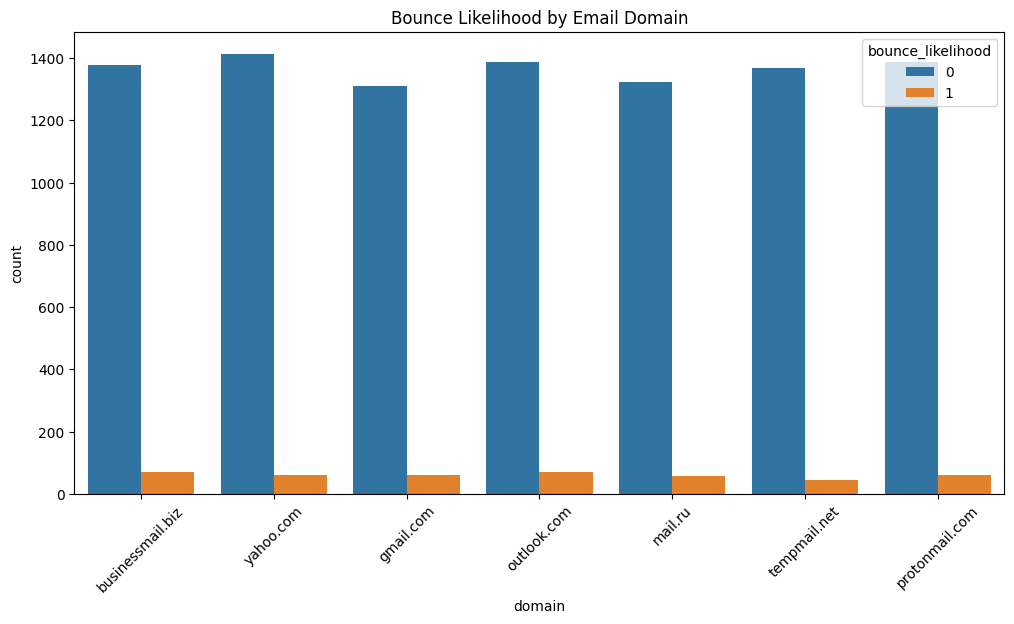

In [14]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='domain', hue='bounce_likelihood')
plt.xticks(rotation=45)
plt.title('Bounce Likelihood by Email Domain')
plt.show()


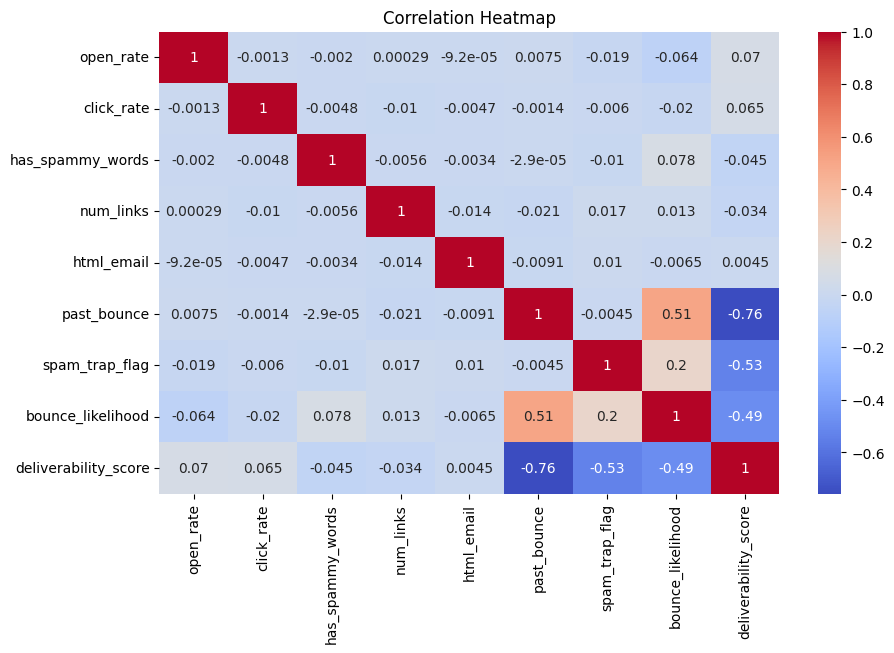

In [15]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [16]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

features = ['open_rate', 'click_rate', 'has_spammy_words', 'num_links', 'html_email', 'past_bounce', 'spam_trap_flag']
X = df[features]
y = df['bounce_likelihood']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1915
           1       0.69      0.53      0.60        85

    accuracy                           0.97      2000
   macro avg       0.84      0.76      0.79      2000
weighted avg       0.97      0.97      0.97      2000



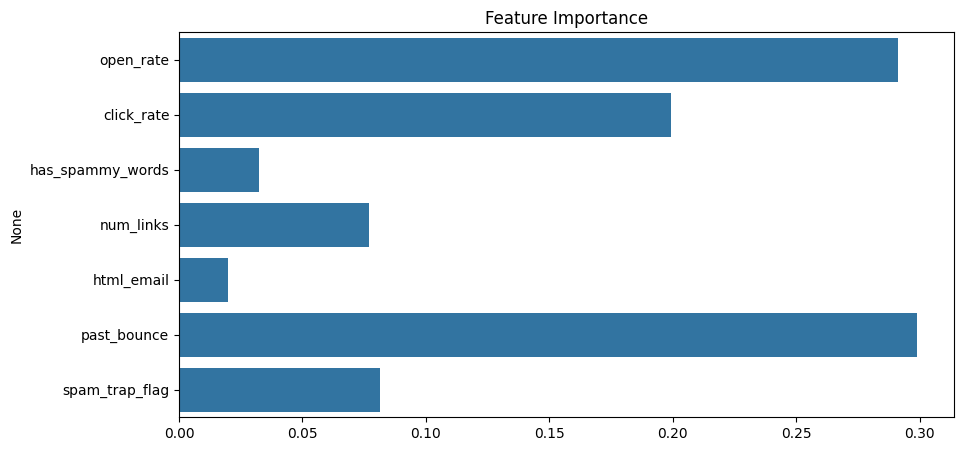

In [17]:

importances = clf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(10, 5))
sns.barplot(x=importances, y=feature_names)
plt.title('Feature Importance')
plt.show()


# **XgBoost Model**

In [18]:
#XgBoost needs to be used

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_xgb))


              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1915
           1       0.65      0.47      0.54        85

    accuracy                           0.97      2000
   macro avg       0.81      0.73      0.76      2000
weighted avg       0.96      0.97      0.96      2000

ROC AUC Score: 0.7295499923206881


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:40:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


#**Handle Class Imbalance**

In [23]:
from sklearn.utils import class_weight

X = df[features]
y = df['bounce_likelihood']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Option A: Adjust class weights
xgb = XGBClassifier(scale_pos_weight=(len(y_train[y_train==0]) / len(y_train[y_train==1])),
                    use_label_encoder=False, eval_metric='logloss')

X_test['actual'] = y_test
X_test['predicted'] = y_pred_xgb
false_negatives = X_test[(X_test['actual'] == 1) & (X_test['predicted'] == 0)]
false_negatives.head()



,open_rate,click_rate,has_spammy_words,num_links,html_email,past_bounce,spam_trap_flag,actual,predicted
8187,0.37,0.05,0,2,1,1,0,1,0
5323,0.05,0.16,0,2,0,0,1,1,0
1224,0.37,0.07,0,2,0,1,0,1,0
7791,0.26,0.06,1,2,1,1,0,1,0
7887,0.11,0.04,0,2,1,1,0,1,0


**Handling class imbalance with xgboost**

In [25]:
# Handle class imbalance
pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=pos_weight)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test[features])  # Use only model features

print(classification_report(y_test, y_pred_xgb))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_xgb))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:48:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1915
           1       0.53      0.66      0.59        85

    accuracy                           0.96      2000
   macro avg       0.76      0.82      0.78      2000
weighted avg       0.97      0.96      0.96      2000

ROC AUC Score: 0.8166180310244201


**Confusion Matrix**

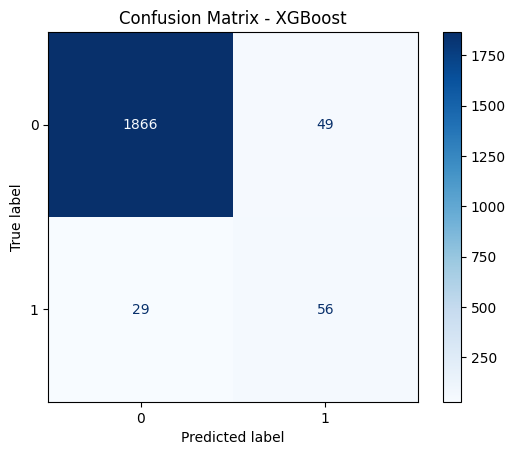

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_xgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - XGBoost")
plt.show()


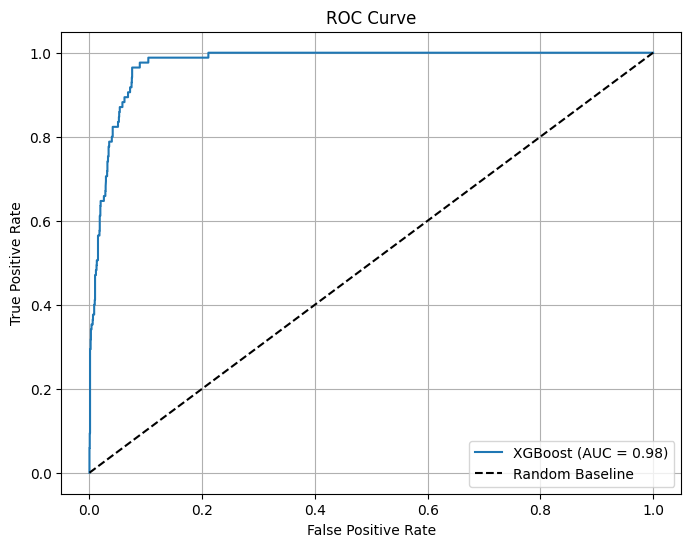

In [28]:
from sklearn.metrics import roc_curve, auc

# Only use original features that the model was trained on
X_test_clean = X_test[features]

# Get probability scores for class 1 (bounce)
y_scores = xgb.predict_proba(X_test_clean)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='Random Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [30]:
# Create export DataFrame with predictions, keeping model input clean
export_df = X_test_clean.copy()
export_df['actual'] = y_test.values
export_df['predicted'] = xgb.predict(X_test_clean[features])
export_df['probability'] = y_scores

# Export to CSV
export_df.to_csv("xgboost_scored_emails.csv", index=False)

from google.colab import files
files.download("xgboost_scored_emails.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>